### Hyperparameter tuning
##### Hyperparameters are those parameters that you set and are not updated on backprpagation, while create the model. To get the best hyperparameters we do hyperparameter tunning
following are three ways:

#### 1) Grid Search
###### You try every combination of hyperparameters and select the combination with best accuracy
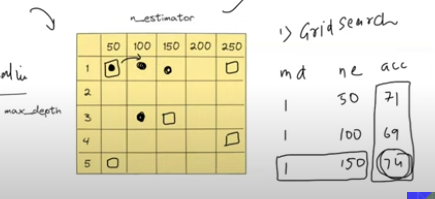

#### 2) Random Search
##### Random search randomly picks some hyperparameter combinations and try them out, and at the end choose the one with best accuracy

#### 3) Optuna
Uses Bayesian Optimization to find the mathematical relation between the hyperparameters and accuracy
##### accuracy = f(hyperparameters)

#### How to code Optuna?
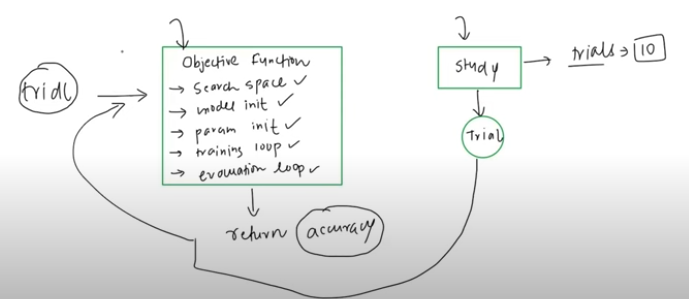

In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn as nn


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.manual_seed(42)

In [4]:
df = pd.read_csv('fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0.0,7.0,0.0,50.0,205.0,196.0,213.0,165.0,0.0,0.0
1,7,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,1,0,0,0,...,142.0,142.0,142.0,21.0,0.0,3.0,0.0,0.0,0.0,0.0
3,8,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0,0,0,0,0,0,0,0,0,...,213.0,203.0,174.0,151.0,188.0,10.0,0.0,0.0,0.0,0.0


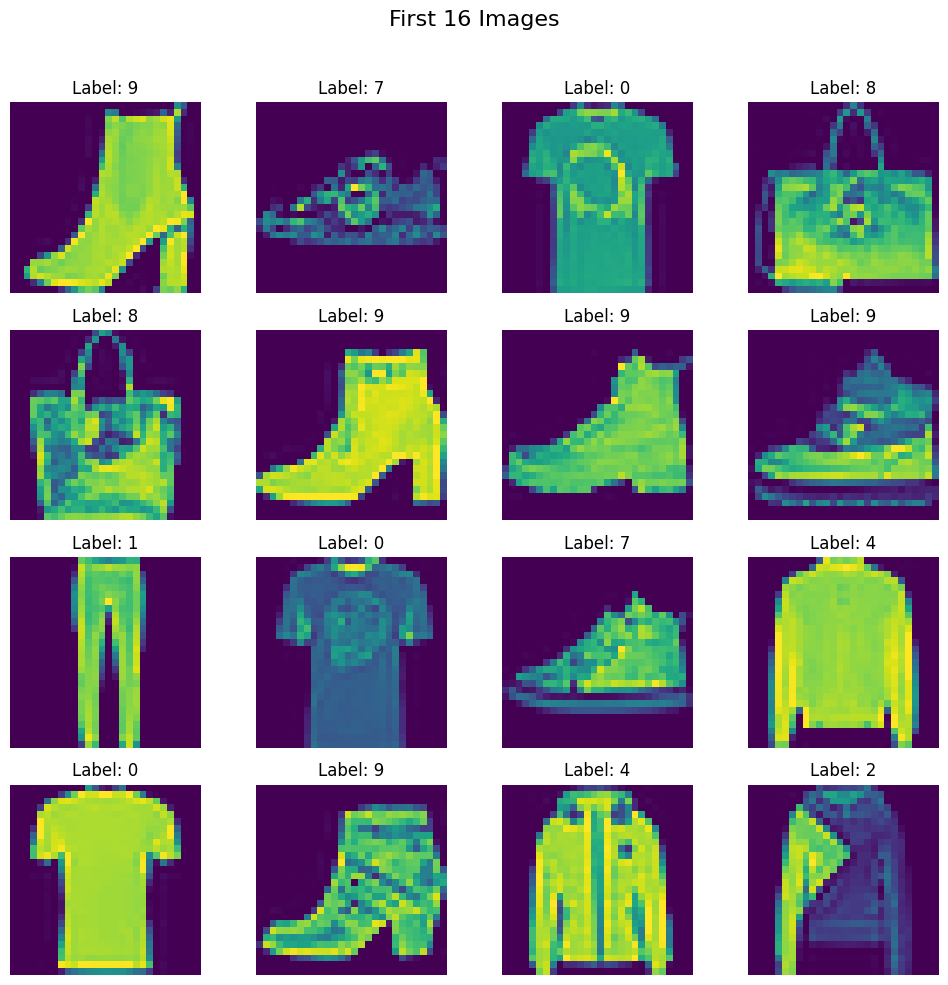

In [5]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [6]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# scaling the feautures
X_train = X_train/255.0
X_test = X_test/255.0

In [9]:
class MyDataset(Dataset):
  def __init__(self,features,labels):
    self.features = torch.tensor(features,dtype=torch.float32)
    self.labels = torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    return self.features[index], self.labels[index]

In [31]:
training_data = MyDataset(X_train,y_train)
test_data = MyDataset(X_test,y_test)

In [32]:
class MyNN(nn.Module):
  def __init__(self, input_dim,output_dim,no_hidden_layers, neurons_per_layer,dr):
    ## input dim : 784
    ## output dim : 10
    super().__init__()
    self.model = self.get_model(input_dim,output_dim,no_hidden_layers, neurons_per_layer,dr)

  def get_model(self , input_dim,output_dim,no_hidden_layers ,neurons_per_layer,dropout_rate):
    layers = []
    for i in range(no_hidden_layers):
      layers.append(nn.Linear(input_dim , neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(p=dropout_rate))

      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer , output_dim))
    model = nn.Sequential(*layers)
    return model

  def forward(self,x):
    ypred_train = self.model(x)
    return ypred_train

In [33]:
### Objective function for Optuna

def objective(trial):
  input_dim = 784
  output_dim = 10
  number_hidden_layers = trial.suggest_int("numm hidden Layers",1,5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer",8,128,step=8)
  epochs = trial.suggest_int("epochs",10,100,step=10)
  learning_rate = trial.suggest_float("lr",1e-5,1e-1,log = True)
  dropout_rate = trial.suggest_float("dropoutrate",0.1,0.5,step = 0.1)
  batch_size = trial.suggest_int("batch size",32 , 128 ,step = 32)
  optim_name = trial.suggest_categorical("optimizer", ["Adam","SGD","RMSprop"])
  weight_decay = trial.suggest_float("weight decay",1e-5,1e-3,log = True)

  train_loader = DataLoader(training_data, shuffle = True,batch_size = batch_size,pin_memory=True)
  test_loader = DataLoader(test_data,shuffle=False,batch_size= batch_size,pin_memory = True) # you cant create randomness in the testing data


  # define model
  model = MyNN(input_dim,output_dim,number_hidden_layers,neurons_per_layer,dropout_rate)
  model.to(device)

  # define parmas
  learning_rate = 0.1
  epochs = 100

  #defining the optimizer
  criterion = nn.CrossEntropyLoss()
  if optim_name == "Adam":
    optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay = weight_decay)
  elif optim_name == "SGD":
    optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay = weight_decay)
  elif optim_name == "RMSprop":
    optimizer = optim.RMSprop(model.parameters(),lr=learning_rate,weight_decay = weight_decay)


  #define the training loop
  for i in range(epochs):
    epoch_loss = 0
    for batch_X,batch_y in train_loader:
      batch_X,batch_y = batch_X.to(device) ,batch_y.to(device)
      outputs = model(batch_X)
      loss = criterion(outputs , batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  # model evaluation
  model.eval()
  total = 0  # <-- initialize here
  correct = 0  # <-- initialize here
  with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X,batch_y = batch_X.to(device) ,batch_y.to(device)
        output = model(batch_X)

        # Get predicted class (index of max value along dim=1)
        _, y_pred = torch.max(output, 1)

        total += batch_y.size(0)  # or len(batch_y)
        correct += (y_pred == batch_y).sum().item()
  accuracy = (correct / total) * 100
  return accuracy

In [24]:
!pip install optuna

In [34]:
import optuna
study = optuna.create_study(direction = "maximize") # As we are working with accuracy so we want to maximize that if we were working with loss we will have to minimize

[I 2025-07-17 07:57:26,638] A new study created in memory with name: no-name-5d7cd4fb-7995-44e3-aeb4-bc0a3229d2a7


In [37]:
study.optimize(objective,n_trials = 25 )

[I 2025-07-17 08:01:21,223] Trial 10 finished with value: 8.588235294117647 and parameters: {'numm hidden Layers': 3, 'neurons_per_layer': 8, 'epochs': 40, 'lr': 0.0013844278407615068, 'dropoutrate': 0.2, 'batch size': 32, 'optimizer': 'RMSprop', 'weight decay': 0.0009896877539029942}. Best is trial 6 with value: 80.58823529411765.
[I 2025-07-17 08:01:34,760] Trial 11 finished with value: 76.47058823529412 and parameters: {'numm hidden Layers': 5, 'neurons_per_layer': 88, 'epochs': 40, 'lr': 0.0010816293800601504, 'dropoutrate': 0.5, 'batch size': 96, 'optimizer': 'SGD', 'weight decay': 3.981263823828826e-05}. Best is trial 6 with value: 80.58823529411765.
[I 2025-07-17 08:01:48,555] Trial 12 finished with value: 79.41176470588235 and parameters: {'numm hidden Layers': 5, 'neurons_per_layer': 88, 'epochs': 10, 'lr': 0.0016709176894856934, 'dropoutrate': 0.5, 'batch size': 96, 'optimizer': 'SGD', 'weight decay': 3.075421424808062e-05}. Best is trial 6 with value: 80.58823529411765.
[I 2

In [38]:
print(study.best_value)
print(study.best_params)

83.41176470588235
{'numm hidden Layers': 3, 'neurons_per_layer': 80, 'epochs': 20, 'lr': 0.0033689474648669507, 'dropoutrate': 0.4, 'batch size': 96, 'optimizer': 'SGD', 'weight decay': 0.0001847970150193852}
